In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


train = pd.read_parquet('/content/drive/MyDrive/DRW Crypto Market Prediction/train.parquet', engine='pyarrow')

# Identify target and feature columns
target_col = 'label'
market_cols = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
feature_cols = [col for col in train.columns if col.startswith('X')]

Mounted at /content/drive


Target variable summary:


,label
count,525886.000000
mean,0.036126
std,1.009915
min,-24.416615
25%,-0.381586
50%,0.016261
75%,0.434137
max,20.740270



Value counts (rounded):


,count
label,
-0.02,3906
0.03,3889
0.00,3865
0.02,3864
-0.01,3860
-0.05,3796
-0.06,3783
0.01,3778
-0.09,3778


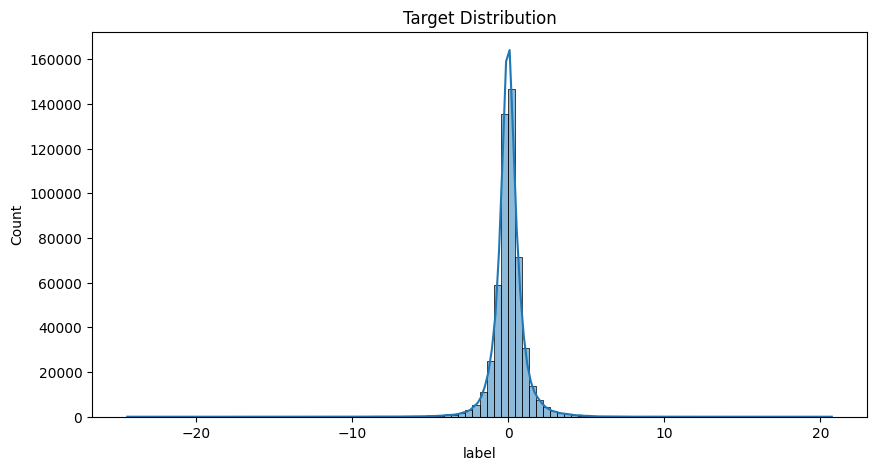

Target min: -24.416614942740008, max: 20.74027012098192
Target mean: 0.03612583479917426, std: 1.0099145156502942
Number of outliers (>5 std): 2104


In [2]:
# target variable analysis

print("Target variable summary:")
display(train[target_col].describe())
print("\nValue counts (rounded):")
display(train[target_col].round(2).value_counts().head(10))

plt.figure(figsize=(10,5))
sns.histplot(train[target_col], bins=100, kde=True)
plt.title('Target Distribution')
plt.xlabel(target_col)
plt.show()

print(f"Target min: {train[target_col].min()}, max: {train[target_col].max()}")
print(f"Target mean: {train[target_col].mean()}, std: {train[target_col].std()}")

# Check for outliers
outlier_threshold = 5 * train[target_col].std()
outliers = train[np.abs(train[target_col]) > outlier_threshold]
print(f"Number of outliers (>5 std): {len(outliers)}")

In [3]:
# target type hypothesis

# Check if target is continuous, discrete, or binary
unique_vals = train[target_col].nunique()
print(f"Unique target values: {unique_vals}")

if unique_vals < 10:
    print("Target is likely categorical or directional (up/down).")
elif unique_vals < 100:
    print("Target is likely discrete (binned returns or price changes).")
else:
    print("Target is likely continuous (returns or price changes).")

# Check if target is centered around 0 (typical for returns)
if abs(train[target_col].mean()) < 0.1:
    print("Target is centered around 0, likely returns or price changes.")
else:
    print("Target is not centered around 0, may be price or other value.")

Unique target values: 525886
Target is likely continuous (returns or price changes).
Target is centered around 0, likely returns or price changes.


Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Time range: 2023-03-01 00:00:00 to 2024-02-29 23:59:00
Frequency (inferred): None
Number of unique timestamps: 525886
Most common time differences:
0 days 00:01:00    525612
0 days 00:02:00       116
0 days 00:03:00        57
0 days 00:04:00        18
0 days 00:08:00        14
Name: count, dtype: int64


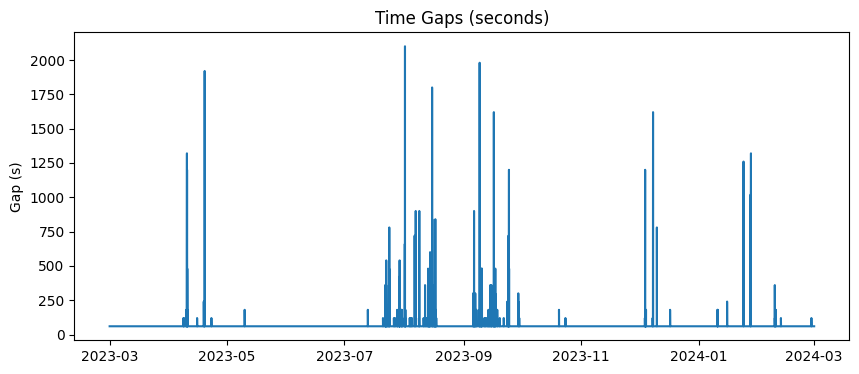

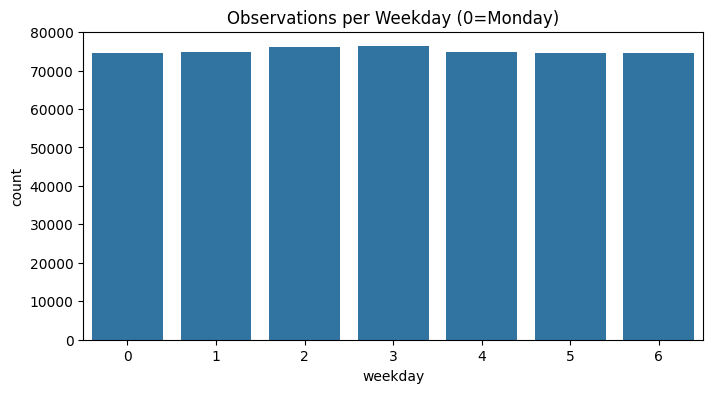

In [4]:
# time structure

# Check index type and time frequency
print(f"Index type: {type(train.index)}")
if isinstance(train.index, pd.DatetimeIndex):
    print(f"Time range: {train.index.min()} to {train.index.max()}")
    print(f"Frequency (inferred): {pd.infer_freq(train.index)}")
    print(f"Number of unique timestamps: {len(train.index.unique())}")
    # Check for gaps
    time_diffs = train.index.to_series().diff().value_counts()
    print("Most common time differences:")
    print(time_diffs.head())
    # Plot time gaps
    plt.figure(figsize=(10,4))
    plt.plot(train.index.to_series().diff().dt.total_seconds())
    plt.title('Time Gaps (seconds)')
    plt.ylabel('Gap (s)')
    plt.show()
else:
    print("Index is not a DatetimeIndex. Check for time column.")

# Check for weekends/holidays
if isinstance(train.index, pd.DatetimeIndex):
    train['weekday'] = train.index.weekday
    plt.figure(figsize=(8,4))
    sns.countplot(x='weekday', data=train)
    plt.title('Observations per Weekday (0=Monday)')
    plt.show()
    train.drop(columns=['weekday'], inplace=True)

In [5]:
# can rows be shuffled?

# Check autocorrelation of target
autocorr = train[target_col].autocorr()
print(f"Target autocorrelation: {autocorr:.3f}")
if abs(autocorr) > 0.1:
    print("Target is autocorrelated. Data should be treated as sequential (time series).")
else:
    print("Target is not autocorrelated. Rows may be shuffled safely (not time series).")

Target autocorrelation: 0.981
Target is autocorrelated. Data should be treated as sequential (time series).


In [6]:
# analyze correlations (target vs features)

# Correlation with market features
corrs = train[market_cols + [target_col]].corr()[target_col].drop(target_col)
print("Correlation of market features with target:")
display(corrs.sort_values(ascending=False))

# Correlation with all features (top 10)
feature_corrs = train[feature_cols].corrwith(train[target_col]).sort_values(key=np.abs, ascending=False)
print("Top 10 features most correlated with target:")
display(feature_corrs.head(10))

Correlation of market features with target:


,label
sell_qty,0.011175
volume,0.008814
buy_qty,0.005616
bid_qty,-0.013220
ask_qty,-0.015761


Top 10 features most correlated with target:


,0
X752,0.090561
X21,0.069401
X20,0.067667
X28,0.064092
X759,0.064057
X29,0.062339
X19,0.062293
X27,0.062251
X22,0.057676
X754,0.057320


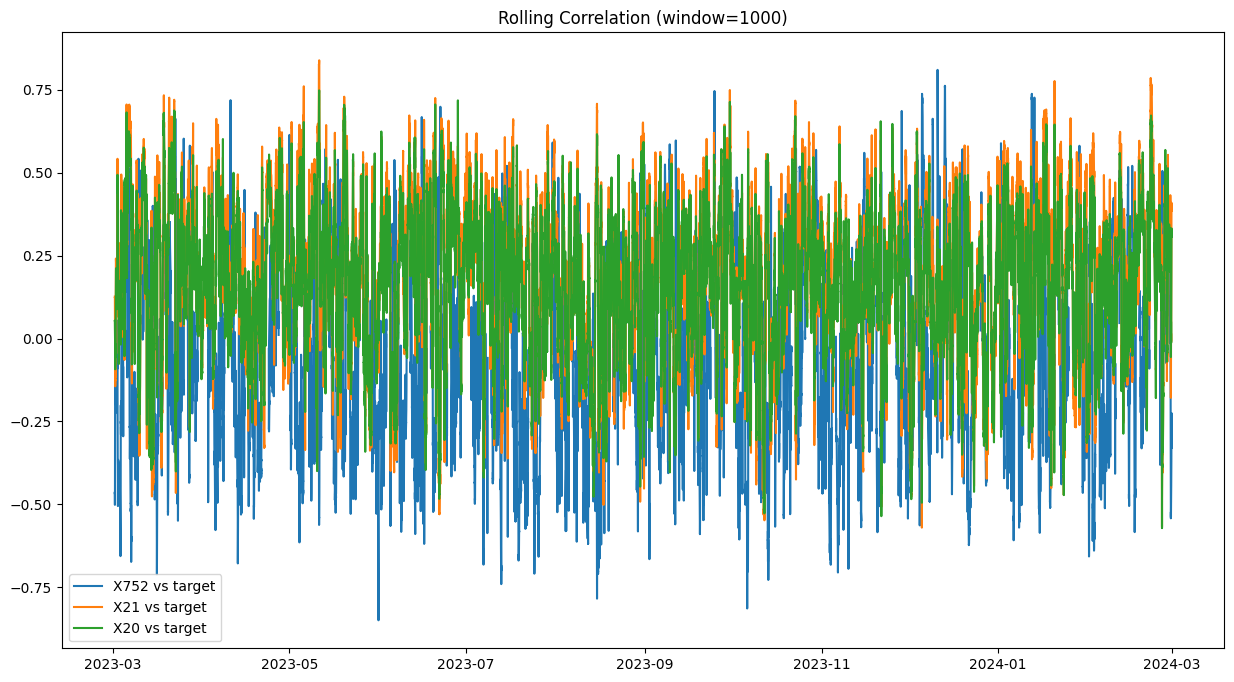

In [7]:
# analyze rolling correlations

# Rolling correlation between top features and target
window = 1000  # adjust as needed
top_features = feature_corrs.head(3).index.tolist()

plt.figure(figsize=(15, 8))
for feat in top_features:
    rolling_corr = train[feat].rolling(window).corr(train[target_col])
    plt.plot(rolling_corr, label=f'{feat} vs target')
plt.title(f'Rolling Correlation (window={window})')
plt.legend()
plt.show()

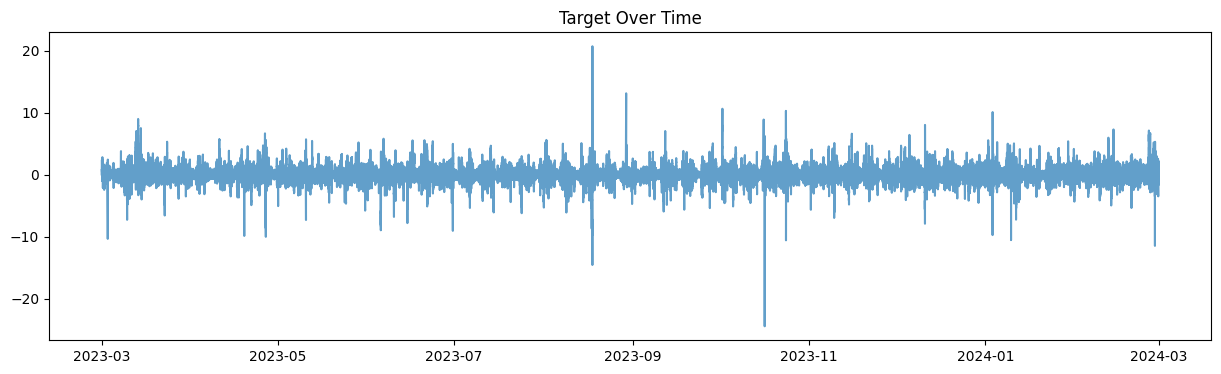

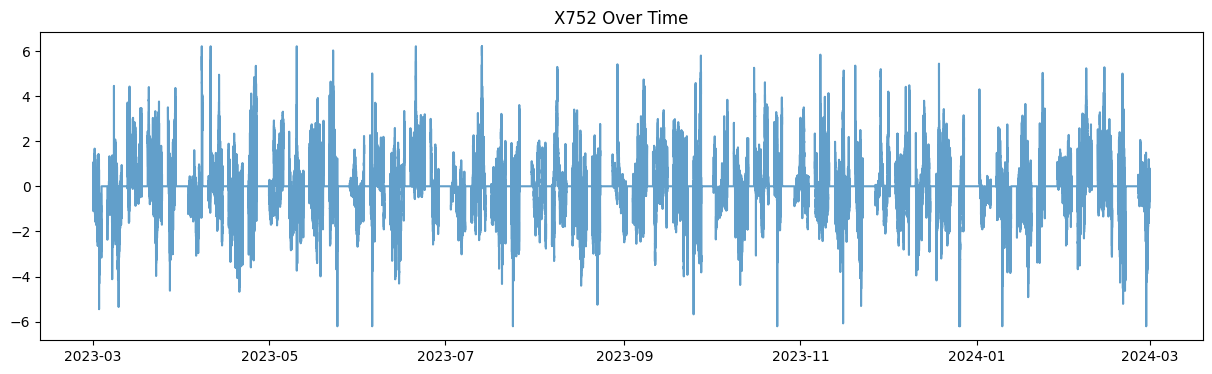

In [8]:
# target and feature stability over time

# Plot target over time
plt.figure(figsize=(15,4))
plt.plot(train.index, train[target_col], alpha=0.7)
plt.title('Target Over Time')
plt.show()

# Plot top feature over time
plt.figure(figsize=(15,4))
plt.plot(train.index, train[top_features[0]], alpha=0.7)
plt.title(f'{top_features[0]} Over Time')
plt.show()

In [9]:
# check for data leakage

# Check for features with perfect correlation to target
perfect_corrs = feature_corrs[np.abs(feature_corrs) > 0.99]
if not perfect_corrs.empty:
    print("WARNING: Features with near-perfect correlation to target (possible leakage):")
    display(perfect_corrs)
else:
    print("No features with perfect correlation to target.")

# Check for features that might contain future information
# (e.g., features that are shifted versions of the target)
for feat in top_features:
    shifted_corr = train[feat].shift(1).corr(train[target_col])
    print(f"Correlation of {feat} (shifted by 1) with target: {shifted_corr:.3f}")
    if abs(shifted_corr) > 0.8:
        print(f"WARNING: {feat} may contain future information (possible leakage).")

No features with perfect correlation to target.
Correlation of X752 (shifted by 1) with target: 0.089
Correlation of X21 (shifted by 1) with target: 0.065
Correlation of X20 (shifted by 1) with target: 0.063
